In [3]:
# ------------------------------------------------------------------------------------- #
# 1. Loading necessary libraries and resources
# ------------------------------------------------------------------------------------- #

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import RFE
from sklearn.metrics import adjusted_rand_score

from pandas.plotting import scatter_matrix

In [4]:
# ------------------------------------------------------------------------------------- #
# 2. Reading in and cleaning data
# ------------------------------------------------------------------------------------- #

### READING IN BEE COMMUNITY DATA ###

# Reading in bee community data - describes bee presence for each site
df = pd.read_csv("Community_Data.csv")
# Checking data looks ok
df.head()

,Site,Agapostemon.texanus,Agapostemon.virescens,Andrena.arabis,Andrena.atlantica,Andrena.banksi,Andrena.barbara,Andrena.bradleyi,Andrena.brevipalpis,Andrena.carlini,...,Osmia.collinsiae,Osmia.cornifrons,Osmia.georgica,Osmia.inspergens,Osmia.lignaria,Osmia.pumila,Osmia.taurus,Osmia.virga,Sphecodes.species,Xylocopa.virginica
0,Andelot,0,0,0,0,0,10,0,0,40,...,1,5,1,0,0,14,13,0,0,0
1,Antietam_Snavely_Woods,0,0,0,0,0,1,0,0,66,...,0,3,0,0,0,0,6,0,0,1
2,Antietam_West_Woods,0,0,0,0,0,0,0,0,48,...,1,2,0,0,0,0,2,0,0,0
3,Arlington_Echo,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,0
4,Audrey_Carroll_Audubon_Sanctuary,0,0,0,0,0,1,0,1,151,...,0,7,0,0,0,1,10,0,0,0


In [5]:
### ADDING TOTAL NUMBER OF SPECIES AND TOTAL NUMBER OF BEES ###

# Counting total number of species present and adding it to the data frame (column = total_species)
# We do this by isolating all the columns containing species counts (so all but the first), then we count the number of these columns which contain a number greater than 0
species_cols = df.columns[1:]
df["total_species"] = (df[species_cols] > 0).sum(axis=1)

In [6]:
# Counting total number of bees present and adding it to the data frame (column = total_bees)
# We do this by adding up all the bee counts across the species columns
df["total_bees"] = df[species_cols].sum(axis=1)

In [7]:
### CALCULATING SIMPSONS DIVERSITY INDEX AND ADDING IT TO DATA TABLE ###

# Calculating simpson's diversity index for each site and adding it to the data frame (column = diverity)
# Calculate proportions (n/N for each species, n = total number of focal species, N = total number of bees overall)
proportions = df[species_cols].div(df["total_bees"].replace(0, np.nan), axis=0)
# We make sure that any rows where total number of bees or species = 0 get a diversity index of 0 (otherwise the formula would return NaNs)

# Simpson's Diversity Index (1 - sum((n/N)^2))
df["diversity"] = 1 - (proportions ** 2).sum(axis=1)

In [8]:
# Exploring this diversity data
# Looking at statistical details (like min, max), and checking if there are any NA values
print(df["diversity"].describe())
print("\nNumber of NAs:", df["diversity"].isna().sum())

count    99.000000
mean      0.784095
std       0.178414
min       0.000000
25%       0.750000
50%       0.851852
75%       0.884445
max       0.942000
Name: diversity, dtype: float64

Number of NAs: 0


<Axes: >

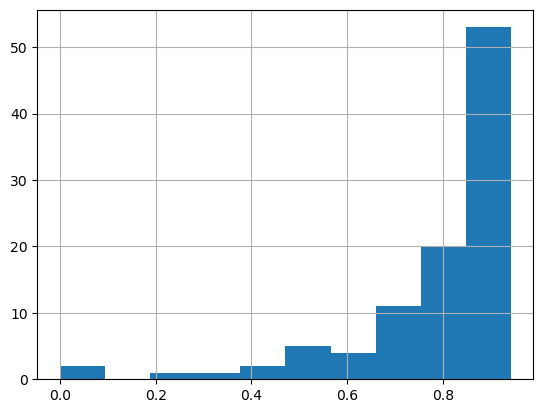

In [9]:
### COMPARING DIFFERENT DIVERSITY METRICS (SIMPSONS DIVERSITY INDEX VS SPECIES NUMBER) ###

# Histogram of diversity data
df["diversity"].hist()
# Very non-normal data, heavily left-skewed

<Axes: >

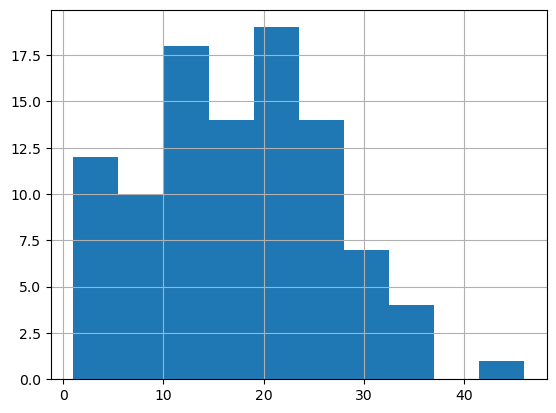

In [10]:
# Histogram of total number of species data
df["total_species"].hist()
# More normal looking, but a bit right skewed

In [11]:
# Method 1: Classifying sites as 'high' or 'low' diversity based on simpsons diversity index
# High diversity = simpsons diversity index higher than the median
# Low diversity = simpsons diversitt index lower than the median
# Creating a column to store this classification (divseristy_class_simpsons)
simpson_median = df["diversity"].median()

df["diversity_class_simpsons"] = np.where(
    df["diversity"] > simpson_median,
    "high",
    "low"
)

# Checking to see how many there are of each category (high diversity vs low diversity sites)
df["diversity_class_simpsons"].value_counts()

diversity_class_simpsons
low     50
high    49
Name: count, dtype: int64

In [12]:
# Method 2: Classifying sites as 'high' or 'low' diversity based on total species number
# High diversity = number of species higher than the median
# Low diversity = number of species lower than the median
# Creating a column to store this classification (divseristy_class_species)
species_median = df["total_species"].median()

df["diversity_class_species"] = np.where(
    df["total_species"] > species_median,
    "high",
    "low"
)

# Checking to see how many there are of each category (high diversity vs low diversity sites)
df["diversity_class_species"].value_counts()

diversity_class_species
low     51
high    48
Name: count, dtype: int64

In [13]:
### READING IN SITE FEATURE DATA ###

# Reading in site features data (things like latitude, longitude, water cover, forest cover, etc.)
site_data = pd.read_csv("Site_Data.csv")

# Check it looks ok
site_data.head()

,Site,Latitude,Longitude,State,County,Northing,Easting,200m_open_water,200m_developed,200m_forest,200m_earlysuccessional,200m_wetlands,1000m_open,1000m_developed,1000m_forest,1000m_earlysuccessional,1000m_wetlands
0,Andelot,39.3115,-76.1768,Maryland,Kent.MD,4352005.12,398545.72,0.137931,0.000000,0.324138,0.096552,0.441379,0.264089,0.000000,0.243291,0.302482,0.185167
1,Antietam_Snavely_Woods,39.4481,-77.7285,Maryland,Washington,4370058.14,265214.61,0.191781,0.184932,0.575342,0.047945,0.000000,0.037412,0.067920,0.351917,0.533748,0.009003
2,Antietam_West_Woods,39.4759,-77.7502,Maryland,Washington,4373200.85,263441.28,0.000000,0.234483,0.110345,0.655172,0.000000,0.000000,0.102803,0.019317,0.876012,0.001868
3,Arlington_Echo,39.0758,-76.6075,Maryland,Anne.Arundel,4326418.00,360948.61,0.103448,0.041379,0.703448,0.000000,0.151724,0.298111,0.174147,0.403183,0.013103,0.075719
4,Audrey_Carroll_Audubon_Sanctuary,39.4213,-77.2059,Maryland,Frederick,4365852.20,310116.00,0.000000,0.000000,0.510345,0.400000,0.089655,0.000000,0.037653,0.256561,0.621851,0.069910


In [14]:
### CREATING A MERGED DATA FRAME (uses a subset of columns from both the bee community data frame and the site feature data frame) ###

# Creating a data table containing only the bee community columns I want to keep
# We no longer needs counts for each specific species, just these diversity metrics will do
bee_summary = df[
    [
        "Site",
        "total_species",
        "total_bees",
        "diversity",
        "diversity_class_simpsons",
        "diversity_class_species"
    ]
]

# Check it looks ok
bee_summary.head()

,Site,total_species,total_bees,diversity,diversity_class_simpsons,diversity_class_species
0,Andelot,26,134,0.868568,high,high
1,Antietam_Snavely_Woods,23,184,0.812559,low,high
2,Antietam_West_Woods,27,134,0.816552,low,high
3,Arlington_Echo,7,8,0.843750,low,low
4,Audrey_Carroll_Audubon_Sanctuary,34,419,0.824021,low,high


In [15]:
# Now merging the bee_summary data frame and the site_data data frame
# This way, for each site, we have various measures of bee diversity and various site descriptors (e.g. water and forest cover)
# We will then be able to look at associations between bee diversity and site characteristics
bees = site_data.merge(
    bee_summary,
    on="Site",
    how="left"
)

# Checking the merged table looks ok
bees.head()

,Site,Latitude,Longitude,State,County,Northing,Easting,200m_open_water,200m_developed,200m_forest,...,1000m_open,1000m_developed,1000m_forest,1000m_earlysuccessional,1000m_wetlands,total_species,total_bees,diversity,diversity_class_simpsons,diversity_class_species
0,Andelot,39.3115,-76.1768,Maryland,Kent.MD,4352005.12,398545.72,0.137931,0.000000,0.324138,...,0.264089,0.000000,0.243291,0.302482,0.185167,26,134,0.868568,high,high
1,Antietam_Snavely_Woods,39.4481,-77.7285,Maryland,Washington,4370058.14,265214.61,0.191781,0.184932,0.575342,...,0.037412,0.067920,0.351917,0.533748,0.009003,23,184,0.812559,low,high
2,Antietam_West_Woods,39.4759,-77.7502,Maryland,Washington,4373200.85,263441.28,0.000000,0.234483,0.110345,...,0.000000,0.102803,0.019317,0.876012,0.001868,27,134,0.816552,low,high
3,Arlington_Echo,39.0758,-76.6075,Maryland,Anne.Arundel,4326418.00,360948.61,0.103448,0.041379,0.703448,...,0.298111,0.174147,0.403183,0.013103,0.075719,7,8,0.843750,low,low
4,Audrey_Carroll_Audubon_Sanctuary,39.4213,-77.2059,Maryland,Frederick,4365852.20,310116.00,0.000000,0.000000,0.510345,...,0.000000,0.037653,0.256561,0.621851,0.069910,34,419,0.824021,low,high


In [16]:
# I will remove columns that we won't be using in the model
# I will remove State and County as they are categorical variables which I don't wish to include in the model
# i will remove Northing and Eassting as we already have Longitude and Latitude
bees = bees.drop(columns=["State", "County", "Northing", "Easting"])

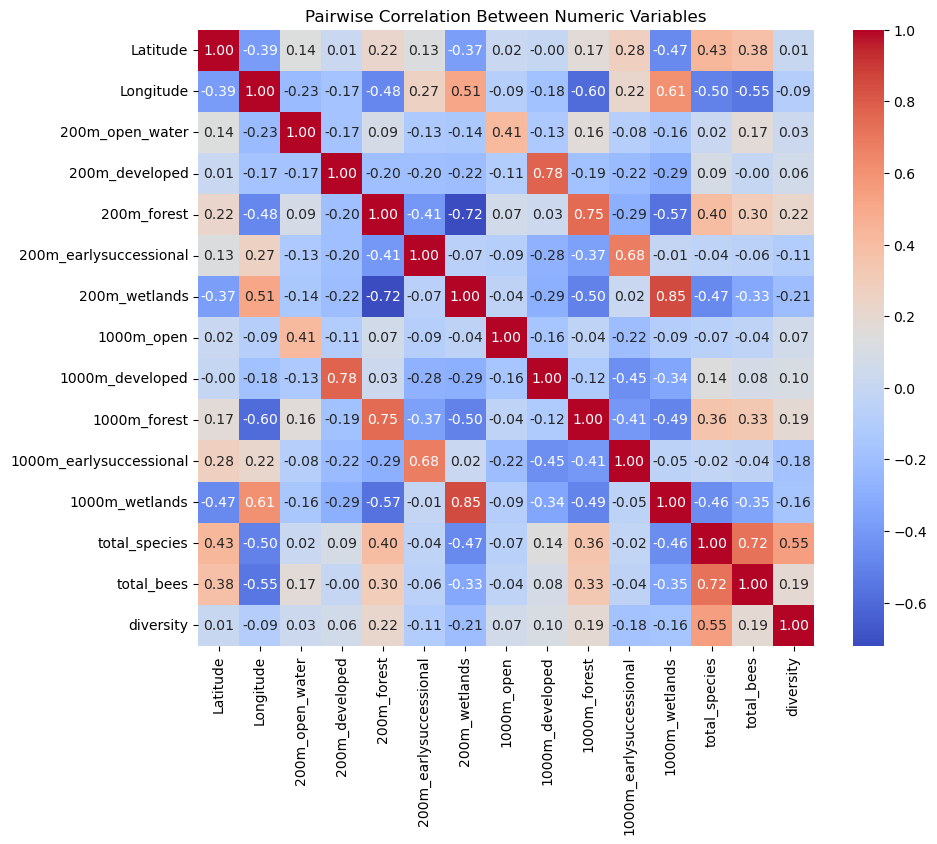

In [17]:
### LOOKING AT RELATIONSHIPS BETWEEN X VARIABLES ###

# Looking at the correlations between all the variables
# Select only numeric columns
numeric_cols = bees.select_dtypes(include="number")
# Compute correlation matrix
corr = numeric_cols.corr()
# Plot a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Pairwise Correlation Between Numeric Variables")
plt.show()

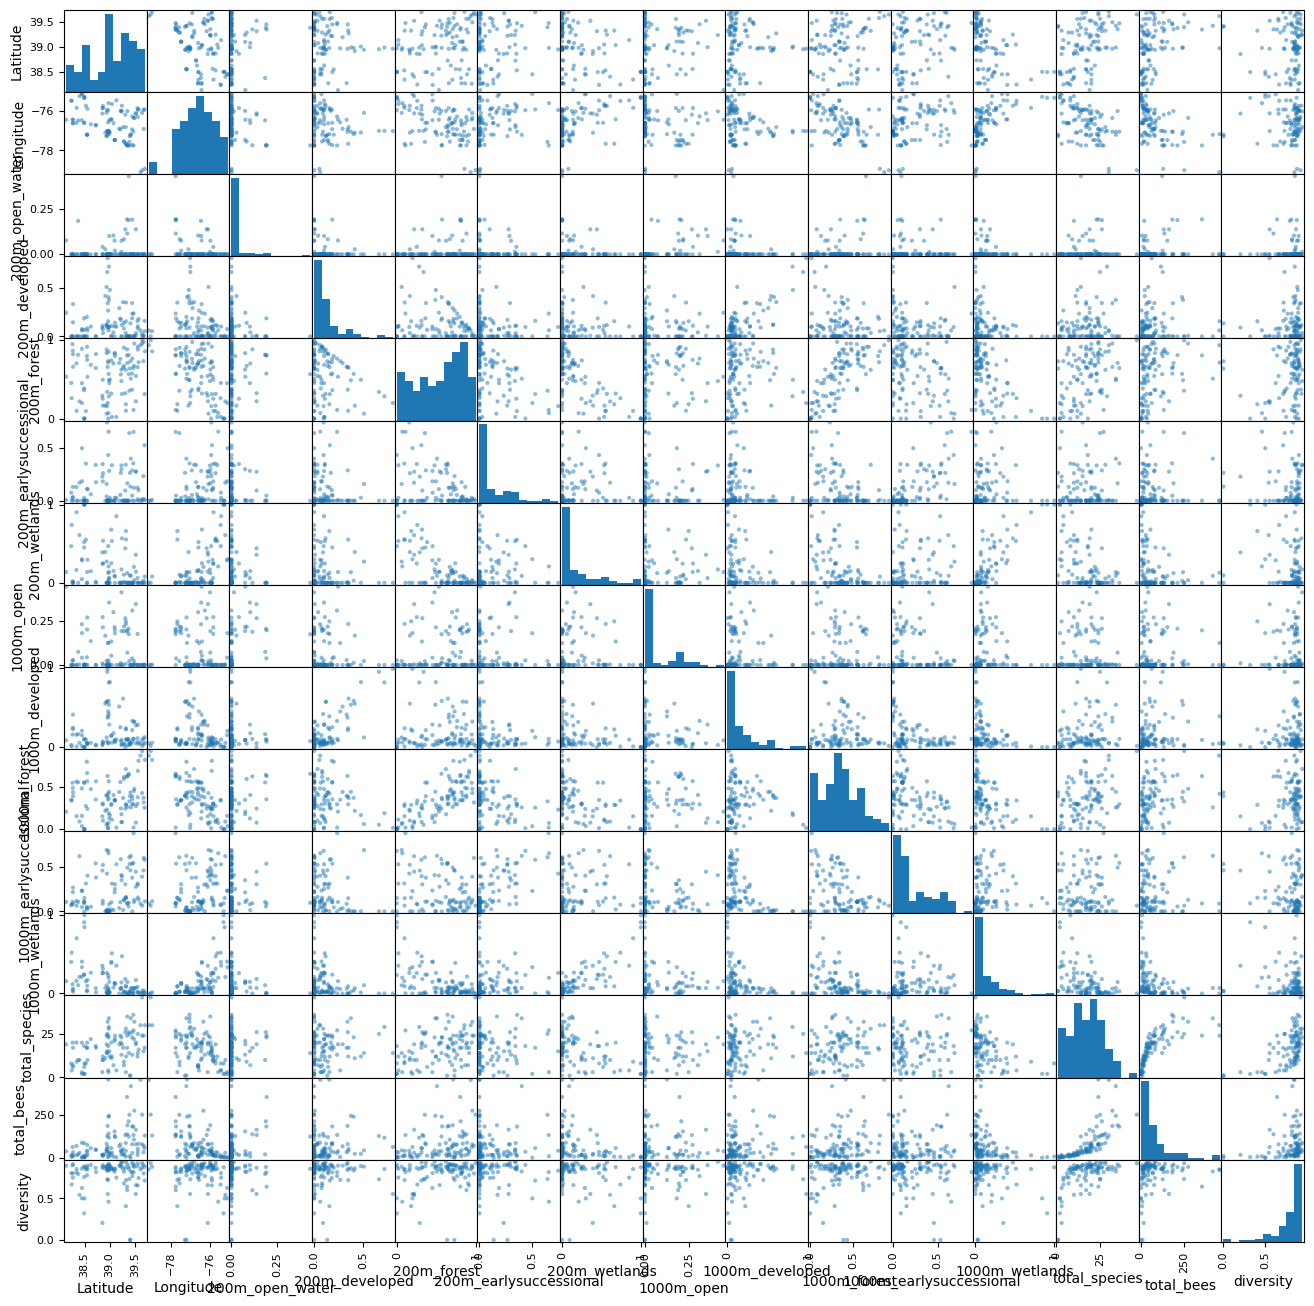

In [18]:
# Multi-variable scatter matrix to further look at relationships between variables
scatter_matrix = scatter_matrix(bees, figsize=(16, 16))

In [19]:
### CHOOSING WHICH COLUMNS TO USE IN THE DATA FRAME WHICH THE MODEL WILL BE TRAINED ON ###

# Bee community columns:
# We have several measures of bee diversity
# For the purposes of this model, I will use total number of bee species as the metric (rather than simpsons diversity index)
# The model will try to predict if a site has high or low diversity
# High diversity = more species than the median across sites
# Low diversoty = fewer species than the median across sites

# Site feature columns:
# The site data looks at proportion the ground cover of habitats like wetland and forest in the area surrounding a transect (within 200m, 1000m)
# (the remaining proportion of the site not described as these different habitat types is agricultural)
# Habitat cover at 200m and 1000m is strongly correlated for each site (makes sense)
# We will exclude 200m cover columns and just use 1000m cover columns

# Creating new data table with selected columns for model training:
# Create a list of columns for modeling
model_cols = [
    "Latitude",
    "Longitude",
    "1000m_open",
    "1000m_developed",
    "1000m_forest",
    "1000m_earlysuccessional",
    "1000m_wetlands",
    "diversity_class_species"  # This is the target variable
]

# Create new DataFrame for modeling
model_data = bees[model_cols].copy()

# Checking new data frame looks ok
model_data.head()

,Latitude,Longitude,1000m_open,1000m_developed,1000m_forest,1000m_earlysuccessional,1000m_wetlands,diversity_class_species
0,39.3115,-76.1768,0.264089,0.000000,0.243291,0.302482,0.185167,high
1,39.4481,-77.7285,0.037412,0.067920,0.351917,0.533748,0.009003,high
2,39.4759,-77.7502,0.000000,0.102803,0.019317,0.876012,0.001868,high
3,39.0758,-76.6075,0.298111,0.174147,0.403183,0.013103,0.075719,low
4,39.4213,-77.2059,0.000000,0.037653,0.256561,0.621851,0.069910,high


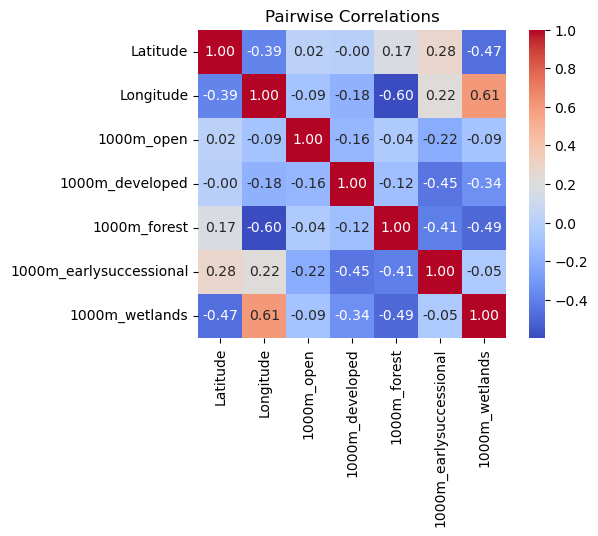

In [20]:
### MAKING SURE MODEL DATA FRAME IS SUITABLE FOR MODELLING ###

# Looking at colinearity again in this reduced dataframe:
# Select only numeric columns
numeric_cols2 = model_data.select_dtypes(include="number")
# Compute correlation matrix
corr2 = numeric_cols2.corr()
# Plot a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr2, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Pairwise Correlations")
plt.show()
# For now I will not be removing any variables based on possible colinearity, as I'd like to run a model including everything first

In [21]:
# Converting the diversity class (high vs low) into a numeric variable
# Convert high to 1, low to 0
model_data["diversity_class_species"] = model_data["diversity_class_species"].map({"low": 0, "high": 1})
# Checking this looks ok
model_data.head()

,Latitude,Longitude,1000m_open,1000m_developed,1000m_forest,1000m_earlysuccessional,1000m_wetlands,diversity_class_species
0,39.3115,-76.1768,0.264089,0.000000,0.243291,0.302482,0.185167,1
1,39.4481,-77.7285,0.037412,0.067920,0.351917,0.533748,0.009003,1
2,39.4759,-77.7502,0.000000,0.102803,0.019317,0.876012,0.001868,1
3,39.0758,-76.6075,0.298111,0.174147,0.403183,0.013103,0.075719,0
4,39.4213,-77.2059,0.000000,0.037653,0.256561,0.621851,0.069910,1


In [22]:
# ------------------------------------------------------------------------------------- #
# 3. Logistic regression model
# ------------------------------------------------------------------------------------- #

### PREPARING THE DATA AND TRAINING THE LOGISTIC REGRESSION MODEL ###

# Importing the model from sklearn
from sklearn.linear_model import LogisticRegression

# Splitting data into features (X) and the data we are trying to predict (y)
X = model_data[['Latitude', 'Longitude', '1000m_open', '1000m_developed', '1000m_forest', '1000m_earlysuccessional', '1000m_wetlands']]
y = model_data['diversity_class_species']

# Standardize features (allow different ranges of numbers to be compared fairly)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Divide training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)
print("Prediction results of the first 5 test samples：", y_pred[:5])
print("Top 5 real results：", y_test.values[:5])

Prediction results of the first 5 test samples： [1 0 1 0 0]
Top 5 real results： [1 0 1 1 0]


Model accuracy：0.60（Proportion of correct predictions）


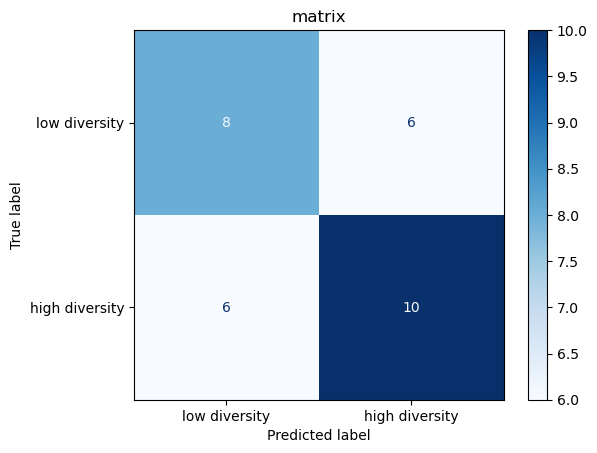

importance of features：
                    features   weights
0                 (Latitude)  0.069482
1                (Longitude) -0.590311
2               (1000m_open)  0.040070
3          (1000m_developed)  0.357365
4             (1000m_forest)  0.356494
5  (1000m_earlysuccessional)  0.186649
6           (1000m_wetlands) -0.229781


In [23]:
### ASSESSING MODEL PERFORMANCE ###

# Calculate model accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy：{accuracy:.2f}（Proportion of correct predictions）")

# Draw confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['low diversity', 'high diversity'])
disp.plot(cmap='Blues')
plt.title('matrix')
plt.show()

# See which features are important
feature_importance = pd.DataFrame({
    'features': ['(Latitude)', '(Longitude)', '(1000m_open)', '(1000m_developed)', '(1000m_forest)', '(1000m_earlysuccessional)', '(1000m_wetlands)'],
    'weights': model.coef_[0]
})
print("importance of features：")
print(feature_importance)

# Summary of confusion matrix:
# Top left: true negatives: 8
# Top right: flase positives (site has low diversity, but model predicts high): 6
# Bottom left: false negatives (site has high diversity, but model predicts low): 6
# Bottom right: true positives: 10

# Our model currently has an accuracy of 0.60 (not great)
# I will try some tweaks to see if I can improve the model at all

In [24]:
### CHECKING FEATURE IMPORTANCE AND EFFECT OF REMOVING FEATURES ON MODEL PERFORMANCE ###

# We will try recursive feature elimination (removing features which do not improve the model's accuracy)
# We have imported recursive feature removal from sklearn for this

# Rank all features by their importance
rfe = RFE(estimator=model, n_features_to_select=1)
rfe.fit(X_train, y_train)

# Feature names
feature_names = ['Latitude', 'Longitude', '1000m_open', '1000m_developed', '1000m_forest', 
                 '1000m_earlysuccessional', '1000m_wetlands']

# Rank features using RFE (1 = most important)
model = LogisticRegression()
rfe = RFE(estimator=model, n_features_to_select=1)
rfe.fit(X_train, y_train)

# Get feature rankings
ranking = rfe.ranking_
feature_ranking = pd.DataFrame({
    'Feature': feature_names,
    'Ranking': ranking
}).sort_values('Ranking')
print("Feature rankings (1 = most important):")
print(feature_ranking)

Feature rankings (1 = most important):
                   Feature  Ranking
1                Longitude        1
6           1000m_wetlands        2
3          1000m_developed        3
4             1000m_forest        4
5  1000m_earlysuccessional        5
0                 Latitude        6
2               1000m_open        7


In [25]:
# Iteratively removing lowest-ranked features and storing model accuracy

# Sort features from lowest importance (highest rank) to highest
features_sorted_by_rank = feature_ranking.sort_values('Ranking', ascending=False)['Feature'].tolist()

results = []

# Start with all features and iteratively remove one at a time
for i in range(len(features_sorted_by_rank)):
    selected_features = features_sorted_by_rank[i:]  # Remove lowest i features
    indices = [feature_names.index(f) for f in selected_features]  # Get column indices
    X_train_selected = X_train[:, indices]
    X_test_selected = X_test[:, indices]

    # Train logistic regression
    model_iter = LogisticRegression()
    model_iter.fit(X_train_selected, y_train)

    # Compute test accuracy
    accuracy = model_iter.score(X_test_selected, y_test)

    results.append({
        'Num_features': len(selected_features),
        'Features': selected_features,
        'Test_accuracy': accuracy
    })

# Convert results to a data frame
results_df = pd.DataFrame(results)
print("\nModel performance as features are removed:")
print(results_df)

# It appears that removing features will not improve the model's accuracy


Model performance as features are removed:
   Num_features                                           Features  \
0             7  [1000m_open, Latitude, 1000m_earlysuccessional...   
1             6  [Latitude, 1000m_earlysuccessional, 1000m_fore...   
2             5  [1000m_earlysuccessional, 1000m_forest, 1000m_...   
3             4  [1000m_forest, 1000m_developed, 1000m_wetlands...   
4             3       [1000m_developed, 1000m_wetlands, Longitude]   
5             2                        [1000m_wetlands, Longitude]   
6             1                                        [Longitude]   

   Test_accuracy  
0       0.600000  
1       0.600000  
2       0.533333  
3       0.533333  
4       0.533333  
5       0.600000  
6       0.600000  


In [26]:
# ------------------------------------------------------------------------------------- #
# 4. Random forest model
# ------------------------------------------------------------------------------------- #

### TRAINING THE RANDOM FOREST MODEL ###

# Importing the model from sklearn
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)
print("Prediction results of the first 5 test samples:", y_pred[:5])
print("Top 5 real results:", y_test.values[:5])

Prediction results of the first 5 test samples: [1 1 1 0 1]
Top 5 real results: [1 0 1 1 0]


Random Forest test accuracy: 0.60


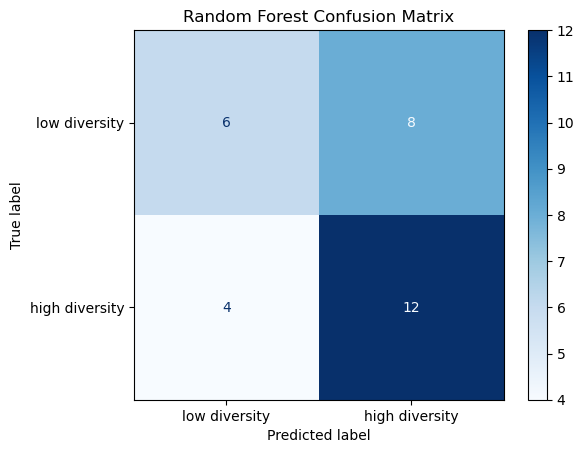

In [27]:
### ASSESSING MODEL PERFORMANCE ###

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest test accuracy: {accuracy:.2f}")

# Random Forest test accuracy: 0.60
# So random forest model is not doing any better than the logistic regression model

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['low diversity', 'high diversity'])
disp.plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Summary of confusion matrix:
# Top left: true negatives: 6
# Top right: flase positives (site has low diversity, but model predicts high): 8
# Bottom left: false negatives (site has high diversity, but model predicts low): 4
# Bottom right: true positives: 12

In [28]:
### CHECKING FEATURE IMPORTANCE ###

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("Random Forest feature importance:")
print(feature_importance)

Random Forest feature importance:
                   Feature  Importance
1                Longitude    0.232953
6           1000m_wetlands    0.190649
4             1000m_forest    0.140840
3          1000m_developed    0.128888
0                 Latitude    0.125878
5  1000m_earlysuccessional    0.109931
2               1000m_open    0.070860


In [29]:
# ------------------------------------------------------------------------------------- #
# 5. K means clustering model
# ------------------------------------------------------------------------------------- #

### TRAINING THE K MEANS CLUSTERING MODEL ###

# Importing model from sklearn
from sklearn.cluster import KMeans

# Determine number of clusters

# We will try 2 using clusters (hopefully they'll align with high vs low diversity)
k = 2
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_scaled)

# Cluster assignments
clusters = kmeans.labels_
print("Cluster assignments for first 10 sites:", clusters[:10])

# Add cluster labels to original DataFrame
clustered_data = model_data.copy()
clustered_data['Cluster'] = clusters

Cluster assignments for first 10 sites: [1 0 1 0 1 0 0 0 1 0]


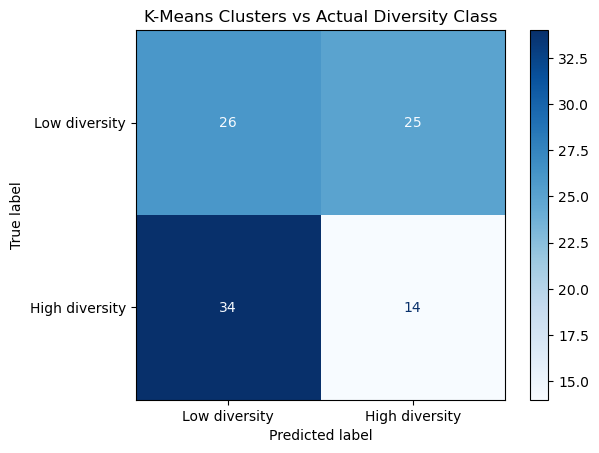

Adjusted Rand Index between clusters and true labels: 0.03
Cluster centers (original scale):
    Latitude  Longitude  1000m_open  1000m_developed  1000m_forest  \
0  39.068117 -77.064697    0.078737         0.247842      0.467632   
1  38.954026 -75.935492    0.073253         0.069383      0.181694   

   1000m_earlysuccessional  1000m_wetlands  
0                 0.138811        0.055016  
1                 0.362739        0.284313  


In [30]:
### ASSESSING MODEL PERFORMANCE ###

# Compare clusters to actual diversity class

# Confusion matrix between clusters and actual classes
cm = confusion_matrix(clustered_data['diversity_class_species'], clustered_data['Cluster'])
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Low diversity", "High diversity"]
)
disp.plot(cmap='Blues')
plt.title('K-Means Clusters vs Actual Diversity Class')
plt.show()

# Summary of confusion matrix:
# (Here, when we lable a site '0' it means it is low diversity, while '1' is high diversity)
# (The cluster model has randomly labelled sites as 0 or 1, so we are seeing if the cluster's labels overlap with our own)
# Top left: both label and cluster = 0: 26
# Top right: mismatch (we label 0, cluster labels 1): 25
# Bottom left: mismatch (we label 1, cluster labels 0): 34
# Bottom right: both label and cluster = 1: 14

# Imported adjusted rand score from sklearn - this lets us check how similar the clustering is to our labels

# Adjusted Rand Index (measures similarity between clusters and true labels, 1 = perfect match)
ari = adjusted_rand_score(clustered_data['diversity_class_species'], clustered_data['Cluster'])
print(f"Adjusted Rand Index between clusters and true labels: {ari:.2f}")

# Adjusted Rand Index between clusters and true labels: 0.03
# So K means clustering has not produced a better model

# Cluster centers - finding out where how the model has clustered sites
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=X.columns)
print("Cluster centers (original scale):")
print(cluster_centers)